# Deep NN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [14]:
# load commons and models module
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
import models 
importlib.reload(cm)
importlib.reload(models)

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


<module 'models' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\bayesian_nlp\\models.py'>

# Configuration, Parameters and Setup

In [4]:
# Only needs to be run once per enviroment. Downloads requiered wordnet package for nltk 
cm.one_time_setup()

# Also make sure to have access to the pretrained GloVe embedding model.
# We use glove.6B.zip from https://nlp.stanford.edu/projects/glove/

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Directory containing the GloVe files.
glove_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/glove"

# Directory containing the trained model
models_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/models"

# Directory containing the training history
history_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/history"

# Embedding dimension (all models are pretrained for dimension 50)
embedding_dim = 50

# Fraction of the dataset to be used as training_data
dataset_sizes=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.005]
trainingset_proportion = dataset_sizes[0]

# hidden layers where each element denotes the number of neurons
neurons_hidden_layers = [64, 64, 32]

# batch size for training
batch_size = 128

# training epochs 
epochs = 5

In [15]:
setup = cm.setup(glove_dir=glove_dir,
                 embedding_dim=embedding_dim,
                 trainingset_proportion=trainingset_proportion)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

# number of data points
N = x_train.shape[0]

Found 400000 word vectors.
17361/88587 unknown words


# Model

In [16]:
default_dense_model = models.DefaultDenseModel(model_setup=setup,
                                               models_dir=models_dir,
                                               history_dir=history_dir,
                                               neurons_hidden_layers=neurons_hidden_layers)

In [17]:
default_dense_model.keras_summary()

Model: "default_dense_24909_64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          4429400   
_________________________________________________________________
dense (Dense)                (None, 1000, 64)          3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 64)          4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1000, 32)          2080      
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 32001     
Total params: 4,470,905
Trainable params: 41,505
Non-trainable params: 4,429,400
_______________________

In [28]:
default_dense_model.fit(epochs=epochs, batch_size=batch_size)

using saved model
Loaded history successfully. Last epoch: 75
Train on 23750 samples, validate on 1250 samples


# History

In [24]:
(history_df, last_epoch) = default_dense_model.load_history()

Loaded history successfully. Last epoch: 75


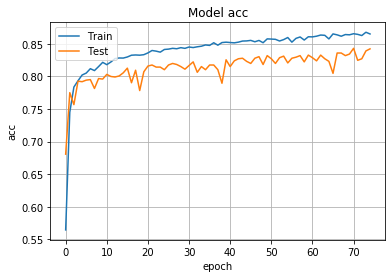

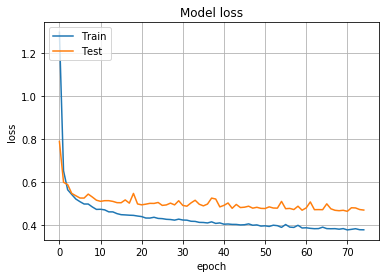

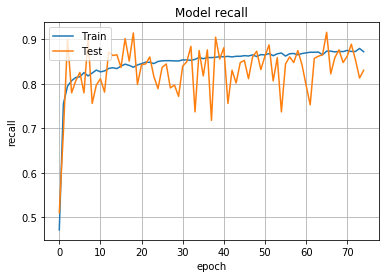

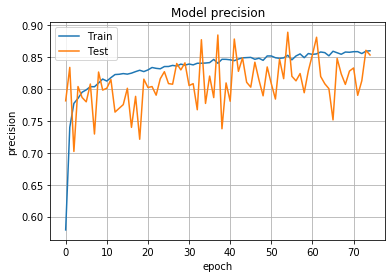

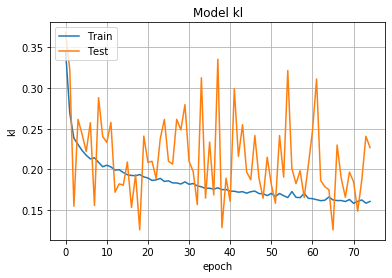

In [29]:
for metric in ["acc", "loss", "recall", "precision", "kl"] :
    cm.plot_metric(metric, history_df)
    plt.show()

In [30]:
def test_model(x, y):
    test_result = np.round(default_dense_model.load_model().predict(x))
    test_errors = np.squeeze(test_result) != y
    correct_percentage = np.sum(test_errors) / len(y)
    print("%i / %i (%.2f%%) are correct" % (len(y) - np.sum(test_errors), len(y), 100 * (1 - correct_percentage)))

In [35]:
test_model(x_test_padded, y_test)

using saved model
20740 / 25000 (82.96%) are correct


In [32]:
sentences = [
    "this was a very bad movie",
    "this was a very good movie",
    "I did not like this movie at all",
    "I hope there will be a sequal",
    "not bad",
    "bad",
    "not good",
    "one of the best movies of the year",
    "the first part was bad but the second part got better",
    "the first part was not bad but after that it just got worse",
    "this film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's is an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with this film witty remarks throughout film were great it was just brilliant so much that i bought"
]

rating = cm.Rating(word_index, default_dense_model.load_model())
rating.print(rating.of(sentences))

using saved model
⭐⭐⭐⭐ (35.20%)
this was a very bad movie

⭐⭐⭐⭐⭐⭐⭐ (71.05%)
this was a very good movie

⭐⭐⭐⭐⭐ (51.22%)
I did not like this movie at all

⭐⭐⭐⭐⭐ (51.31%)
I hope there will be a sequal

⭐⭐⭐ (26.74%)
not bad

⭐⭐⭐⭐⭐ (51.37%)
bad

⭐⭐⭐⭐⭐⭐⭐ (67.21%)
not good

⭐⭐⭐⭐⭐⭐ (64.59%)
one of the best movies of the year

⭐⭐⭐ (34.64%)
the first part was bad but the second part got better

⭐ (14.76%)
the first part was not bad but after that it just got worse

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ (98.22%)
this film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's is an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with this film witty remarks throughout film were great it was just brilliant so much that i bought

